In [1]:
from ptc import calculate_gain, calculate_readout_noise
import glob

In [2]:
from astropy.table import Table

tab = Table.read("/home/jovyan/work/ccd-reductions-Jbhandol/reduction_output/HAT-P-36 b_photometry_master.ecsv", format="ascii.ecsv")

In [3]:
# Paths to my FITS files for relevant calculations of gain and read noise
flat_files = [
    '/home/jovyan/work/ccd-reductions-Jbhandol/20250603/domeflat_z_001.fits',
    '/home/jovyan/work/ccd-reductions-Jbhandol/20250603/domeflat_z_002.fits'
]
bias_files = [
    '/home/jovyan/work/ccd-reductions-Jbhandol/20250603/Bias_BIN1_20250604_033112.fits',
    '/home/jovyan/work/ccd-reductions-Jbhandol/20250603/Bias_BIN1_20250604_033126.fits'
]

In [4]:
gain = calculate_gain(flat_files)
print(f"Gain = {gain:.2f} e-/ADU")

Gain = 1.37 e-/ADU


In [5]:
read_noise = calculate_readout_noise(bias_files, gain)
print(f"Read Noise = {read_noise:.2f} e-")

Read Noise = 22.56 e-


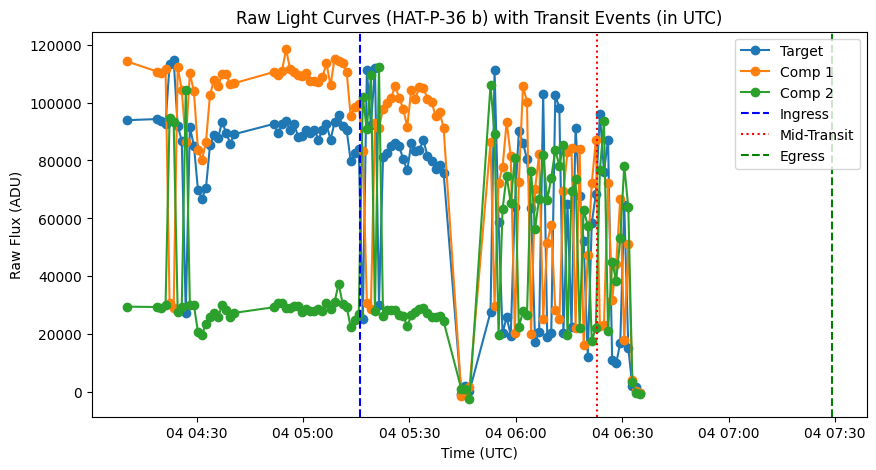

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time

# I am loading the flux data for all three stars from my master table.
flux = tab['flux_r20']
n_stars = 3
n_rows = len(tab)
n_frames = n_rows // n_stars

# Reshaping my flux array so each row is a different frame, columns are stars. This makes my life easier!
flux_r20 = np.array(tab['flux_r20']).reshape(n_frames, n_stars)
# Time is already in JD in my table, so I'm just grabbing every n_stars-th value.
time_jd = np.array(tab['time_obs'])[::n_stars]

target_flux = flux_r20[:, 0]
comp1_flux  = flux_r20[:, 1]
comp2_flux  = flux_r20[:, 2]

# --- Adding predicted transit event times in UTC just to see if my plot lines up with the real event ---
t_ingress_utc = "2025-06-04 05:16"
t_midtransit_utc = "2025-06-04 06:23"
t_egress_utc = "2025-06-04 07:29"

# Converting these UTC times to JD (so I can plot vertical lines at the right place)
t_ingress_jd = Time(t_ingress_utc, format='iso', scale='utc').jd
t_midtransit_jd = Time(t_midtransit_utc, format='iso', scale='utc').jd
t_egress_jd = Time(t_egress_utc, format='iso', scale='utc').jd

# -- Converting JD array to UTC datetime for plotting on x-axis (it's so much easier to look at real clock times!)
time_utc = Time(time_jd, format='jd').to_datetime()

plt.figure(figsize=(10,5))

# Plotting raw flux for each star
plt.plot(time_utc, target_flux, 'o-', label='Target')
plt.plot(time_utc, comp1_flux, 'o-', label='Comp 1')
plt.plot(time_utc, comp2_flux, 'o-', label='Comp 2')

# Converting the event JD to UTC datetime for x-axis (so lines show up in the right spot)
plt.axvline(Time(t_ingress_jd, format='jd').to_datetime(), color='blue', linestyle='--', label='Ingress')
plt.axvline(Time(t_midtransit_jd, format='jd').to_datetime(), color='red', linestyle=':', label='Mid-Transit')
plt.axvline(Time(t_egress_jd, format='jd').to_datetime(), color='green', linestyle='--', label='Egress')

plt.xlabel("Time (UTC)")  # Just a note to myself, now it’s not JD anymore
plt.ylabel("Raw Flux (ADU)")
plt.legend()
plt.title("Raw Light Curves (HAT-P-36 b) with Transit Events (in UTC)")

# Let's save the plot as a PNG so I can put it in my paper
plt.savefig("raw_light_curves_utc.png", dpi=200, bbox_inches='tight')

plt.show()


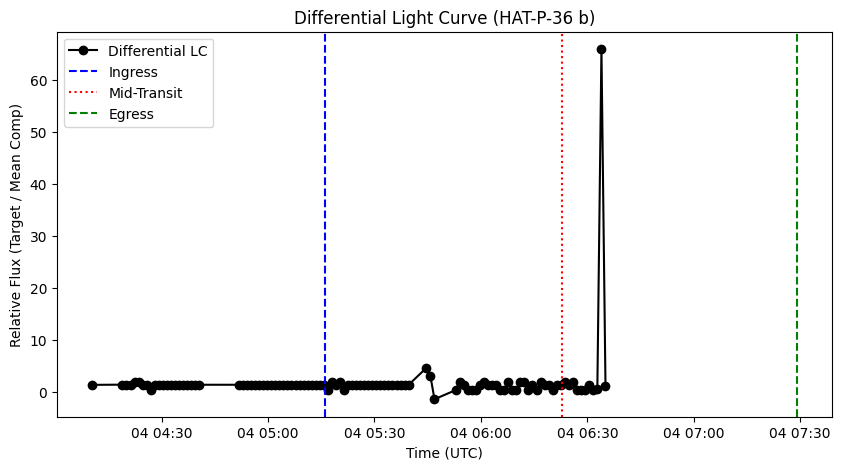

In [11]:
# Now I want to make my differential light curve

# I just average my two comparison stars and hope it is enough
comp_flux = np.mean([comp1_flux, comp2_flux], axis=0)
diff_flux = target_flux / comp_flux

# here i plot. I’m switching the time axis to UTC again, because looking at JD just makes my brain tired :(
plt.figure(figsize=(10,5))
plt.plot(time_utc, diff_flux, 'ko-', label='Differential LC')

# Plot vertical lines for the transit, using UTC so they match the data
plt.axvline(Time(t_ingress_jd, format='jd').to_datetime(), color='blue', linestyle='--', label='Ingress')
plt.axvline(Time(t_midtransit_jd, format='jd').to_datetime(), color='red', linestyle=':', label='Mid-Transit')
plt.axvline(Time(t_egress_jd, format='jd').to_datetime(), color='green', linestyle='--', label='Egress')

plt.xlabel("Time (UTC)")  # much better than JD!
plt.ylabel("Relative Flux (Target / Mean Comp)")
plt.legend()
plt.title("Differential Light Curve (HAT-P-36 b)")

# save this plot too
plt.savefig("differential_light_curve_utc.png", dpi=200, bbox_inches='tight')

plt.show()


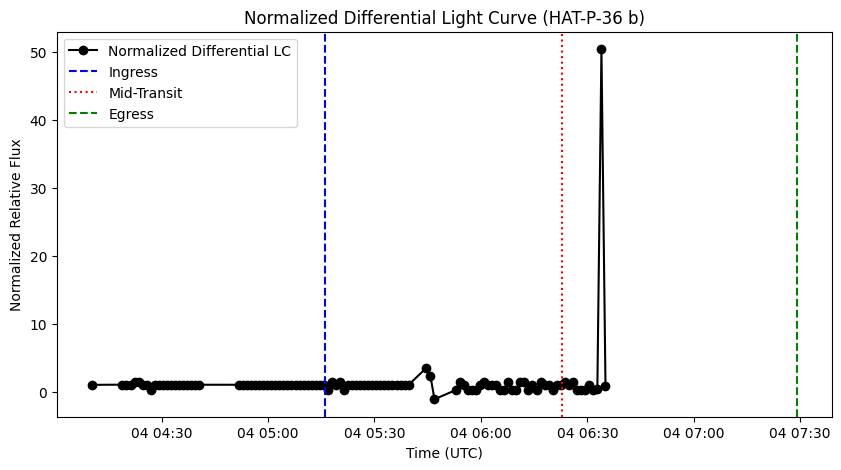

In [14]:
# Okay, now it's time for the normalizing the differential light curve.
# Grabing only those points that are before ingress, these are hopefully "just normal"
baseline = diff_flux[time_jd < t_ingress_jd]
norm = np.median(baseline)  # I trust the median more than mean, in case of some wild outlier

# Let's normalize everything, hopefully i see a dip:( no i didnt
norm_diff_flux = diff_flux / norm

plt.figure(figsize=(10,5))
plt.plot(time_utc, norm_diff_flux, 'ko-', label='Normalized Differential LC')

# The vertical lines again, always in UTC so they show up in the right spot
plt.axvline(Time(t_ingress_jd, format='jd').to_datetime(), color='blue', linestyle='--', label='Ingress')
plt.axvline(Time(t_midtransit_jd, format='jd').to_datetime(), color='red', linestyle=':', label='Mid-Transit')
plt.axvline(Time(t_egress_jd, format='jd').to_datetime(), color='green', linestyle='--', label='Egress')

plt.xlabel("Time (UTC)") 
plt.ylabel("Normalized Relative Flux")
plt.legend()
plt.title("Normalized Differential Light Curve (HAT-P-36 b)")

# Saving my “final boss” plot. 
plt.savefig("normalized_differential_light_curve_utc.png", dpi=200, bbox_inches='tight')

plt.show()


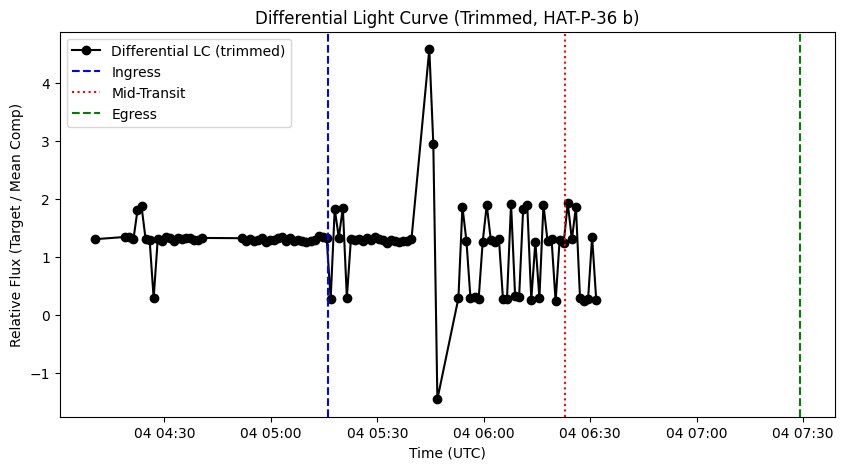

In [15]:
# The last few data points are just a mess—clouds, telescope slewing, who knows!
# So I just chop off the last 3 points from all my arrays and hope the light curve gets cleaner.

#littl improvement but not a dip. Howevevr, some noise after ingress. It says something i guess?
time_jd_trimmed      = time_jd[:-3]
time_utc_trimmed     = time_utc[:-3]
target_flux_trim     = target_flux[:-3]
comp1_flux_trim      = comp1_flux[:-3]
comp2_flux_trim      = comp2_flux[:-3]

# I do my differential calculation again, just with the trimmed data
comp_flux_trim = np.mean([comp1_flux_trim, comp2_flux_trim], axis=0)
diff_flux_trim = target_flux_trim / comp_flux_trim

plt.figure(figsize=(10,5))
plt.plot(time_utc_trimmed, diff_flux_trim, 'ko-', label='Differential LC (trimmed)')

# Vertical lines for the transit events, still in UTC (so my brain doesn’t explode)
plt.axvline(Time(t_ingress_jd, format='jd').to_datetime(), color='blue', linestyle='--', label='Ingress')
plt.axvline(Time(t_midtransit_jd, format='jd').to_datetime(), color='red', linestyle=':', label='Mid-Transit')
plt.axvline(Time(t_egress_jd, format='jd').to_datetime(), color='green', linestyle='--', label='Egress')

plt.xlabel("Time (UTC)")
plt.ylabel("Relative Flux (Target / Mean Comp)")
plt.legend()
plt.title("Differential Light Curve (Trimmed, HAT-P-36 b)")

# Saving this plot too
plt.savefig("differential_light_curve_trimmed_utc.png", dpi=200, bbox_inches='tight')

plt.show()
